# Evaluating the Model

### Install Requirements

In [26]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn

### Import Required Libraries

In [27]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms

### Specify Model

There are several output folders from training multiple models.  

In [3]:
# set this to today's date
today = "2023-09-11"

# modify output folder suffix if needed
suffix = "kfold_train_2"

# name of output folder
output_folder = today + "_" + suffix

k = 1

In [4]:
dataset = fo.Dataset.from_dir(
    data_path="/home/jovyan/work/data/",
    labels_path=f"/home/jovyan/work/{output_folder}/test_{k}.json",
    dataset_type=fo.types.COCODetectionDataset, 
    name=f"test_{today}_{k}",
    label_types="segmentations"
)


 100% |███████████████████| 35/35 [7.7s elapsed, 0s remaining, 4.3 samples/s]      


In [5]:
print(dataset)

Name:        test_2023-09-11_1
Media type:  image
Num samples: 35
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [6]:
base_path = f"/home/jovyan/work/{output_folder}/fold_{k}/"

leaf_cfg = get_cfg()
leaf_cfg.MODEL.DEVICE='cpu'
leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

leaf_predictor = DefaultPredictor(leaf_cfg)

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

[03/05 20:36:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/2023-09-11_kfold_train_2/fold_1/model_final.pth ...


namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [7]:
from IPython.display import display


In [8]:


with fo.ProgressBar() as pb:
    for sample in pb(dataset):

        # run interence on selected image
        image = Image.open(sample.filepath)
        image = ImageOps.exif_transpose(image)
        
        image_arr = np.array(image)
        h, w, c = image_arr.shape
        print (h,w,c)
        outputs = leaf_predictor(image_arr)
        
        # get bboxes and class labels
        pred_boxes = outputs["instances"].pred_boxes.tensor.numpy()
        pred_masks = outputs["instances"].pred_masks.numpy()
        class_labels = outputs["instances"].pred_classes.numpy()
        scores = outputs["instances"].scores.numpy()
        
        # track indicies of 
        qr_indices = []
        leaf_indices = []
        red_square_indices = []
        
        # get indices of leaves and qr codes
        for i, label in enumerate(class_labels):
            if label == 0: # leaf
                leaf_indices.append(i)
            elif label == 1: # qr
                qr_indices.append(i)
            elif label == 2: # red-square
                red_square_indices.append(i)
                
        classes = ['leaf', 'qr', 'red-square']
        
        detections = []
        
        # track pixel 
        red_square_pixels = 0
        leaf_pixels = 0
        qr_pixels = 0
        
        for label, mask, box, score in zip(class_labels, pred_masks, pred_boxes, scores):
           
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
            
            bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
            mask_h, mask_w = bbox_mask.shape
            
            mask_pixel_count = np.count_nonzero(mask)
            class_label = classes[label]
            
            # print('label: ', class_label)
            # print('mask_pixel_count: ', mask_pixel_count)
            
            if class_label == 'leaf':
                leaf_pixels += mask_pixel_count
            elif class_label == 'red-square':
                red_square_pixels = mask_pixel_count
            elif class_label == 'qr':
                qr_pixels = mask_pixel_count

            
            
            # print(mask.shape)
            # print(np.count_nonzero(mask))
            
            # print(rel_box)
            
            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                )
            )
        
        
        print('image: ', sample.filepath)
        print('red_square_pixels: ', red_square_pixels)
        print('leaf_pixels: ', leaf_pixels)
        print('qr_pixels: ', qr_pixels)
        
        leaf_area = None
        
        if red_square_pixels:
            leaf_area = (4 * leaf_pixels) / red_square_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        elif qr_pixels:
            leaf_area = (1.44 * leaf_pixels) / qr_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        
        sample["predictions"] = fo.Detections(detections=detections)
        sample["height"] = h
        sample["width"] = w
        sample["area"] = leaf_area
        
        sample.save()


        

   0% ||------------------|  0/35 [9.7ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


6960 4640 3                                                                 
image:  /home/jovyan/work/data/leaves/IMG_5850.JPG
red_square_pixels:  0
leaf_pixels:  105124
qr_pixels:  296788
leaf area: 0.5100562017332237 cm2
6960 4640 3                                                                     
image:  /home/jovyan/work/data/leaves/IMG_5856.JPG
red_square_pixels:  0
leaf_pixels:  0
qr_pixels:  314429
leaf area: 0.0 cm2
6960 4640 3                                                                      
image:  /home/jovyan/work/data/leaves/IMG_5862.JPG
red_square_pixels:  0
leaf_pixels:  0
qr_pixels:  262931
leaf area: 0.0 cm2
4640 6960 3                                                                      
image:  /home/jovyan/work/data/leaves/IMG_5873.JPG
red_square_pixels:  1103552
leaf_pixels:  86761
qr_pixels:  296224
leaf area: 0.314479063967987 cm2
4640 6960 3                                                                      
image:  /home/jovyan/work/data/leaves/IMG_58

In [9]:
print(dataset.last())
!pip install openpyxl

<Sample: {
    'id': '65e7822c92bb5e5bafac5414',
    'media_type': 'image',
    'filepath': '/home/jovyan/work/data/leaves/new_batch/IMG_6042.JPG',
    'tags': [],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 6960,
        'height': 4640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '65e7822c92bb5e5bafac540d',
                'attributes': {},
                'tags': [],
                'label': 'red-square',
                'bounding_box': [
                    0.06833923903072406,
                    0.5208700670093828,
                    0.16655131907487838,
                    0.2387781196073502,
                ],
                'mask': array([[False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, Fa

In [10]:
import pandas as pd

df = pd.read_excel('/home/jovyan/work/First_batch_area.xlsx')
df['ml_area'] = None
df['ml_area'] = df['ml_area'].astype(float)
print(df)


          picture  area_cm2  ml_area
0    IMG_5792.tif      0.16      NaN
1    IMG_5793.tif      0.07      NaN
2    IMG_5794.tif      0.37      NaN
3    IMG_5795.tif      0.09      NaN
4    IMG_5849.tif      0.66      NaN
..            ...       ...      ...
174  IMG_6055.tif      4.70      NaN
175  IMG_6056.tif     16.53      NaN
176  IMG_6057.tif      0.83      NaN
177  IMG_6058.tif      0.55      NaN
178  IMG_6059.tif      4.95      NaN

[179 rows x 3 columns]


In [11]:
missing = []

for sample in dataset:

    filename = sample.filepath.split('/')[-1].split('.')[0]
    print(filename)
    print(sample.area)
    
    if not df.loc[df['picture'].str.startswith(filename)].empty:
        df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
    else:
        missing.append(filename)

print(df)
print(missing)


    

IMG_5850
0.5100562017332237
IMG_5856
0.0
IMG_5862
0.0
IMG_5873
0.314479063967987
IMG_5874
0.285654357152205
IMG_5875
0.38367227589473035
IMG_5910
0.1570128612916609
IMG_5913
0.1257046540629705
IMG_5914
0.24731576606709743
IMG_5919
0.0
IMG_5922
0.17815920556467624
IMG_5925
0.283107228591341
IMG_5933
0.13849809961992396
IMG_5935
0.22205120850484714
IMG_5936
0.10379750138182717
IMG_5937
0.2578048290739209
IMG_5938
0.14630591319732505
IMG_5939
0.126219031714705
IMG_5947
2.1299548605673975
IMG_5953
0.34671282320030117
IMG_5955
3.3164782883776445
IMG_5968
1.6368610664194065
IMG_5969
1.6281906458010604
IMG_5971
2.8285538036733224
IMG_5972
0.41148818305145085
IMG_5978
0.023728082056556216
IMG_5987
0.03499820073352639
IMG_5995
3.552919875341267
IMG_6016
0.44478218218494825
IMG_6024
0.8969209130196165
IMG_6027
0.5364063296823741
IMG_6028
0.05013491218209281
IMG_6034
0.7998212167574908
IMG_6040
0.7994232323847129
IMG_6042
0.7975605204675387
          picture  area_cm2  ml_area
0    IMG_5792.tif  

In [12]:
df_area = df[df['ml_area'] >= 0.0]
print(df_area)
df.dtypes

          picture  area_cm2  ml_area
5    IMG_5850.tif      0.91     0.51
11   IMG_5856.tif      0.52     0.00
17   IMG_5862.tif      0.35     0.00
26   IMG_5873.tif      0.35     0.31
27   IMG_5874.tif      0.29     0.29
28   IMG_5875.tif      0.41     0.38
37   IMG_5910.tif      0.19     0.16
40   IMG_5913.tif      0.14     0.13
41   IMG_5914.tif      0.34     0.25
46   IMG_5919.tif      0.00     0.00
49   IMG_5922.tif      0.20     0.18
52   IMG_5925.tif      0.03     0.28
60   IMG_5933.tif      0.12     0.14
62   IMG_5935.tif      0.20     0.22
63   IMG_5936.tif      0.12     0.10
64   IMG_5937.tif      0.37     0.26
65   IMG_5938.tif      0.16     0.15
66   IMG_5939.tif      0.13     0.13
74   IMG_5947.tif      2.29     2.13
80   IMG_5953.tif      0.46     0.35
82   IMG_5955.tif      3.58     3.32
94   IMG_5968.tif      1.75     1.64
95   IMG_5969.tif      1.74     1.63
97   IMG_5971.tif      2.97     2.83
98   IMG_5972.tif      0.44     0.41
104  IMG_5978.tif      0.12     0.02
1

picture      object
area_cm2    float64
ml_area     float64
dtype: object

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


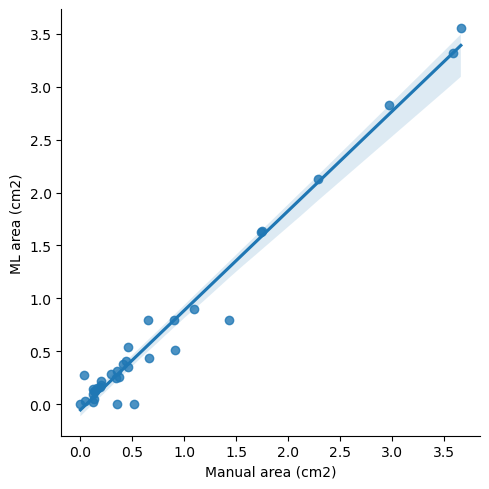

In [13]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual area (cm2)', ylabel='ML area (cm2)')

In [14]:
df_area.corr(numeric_only=True)

,area_cm2,ml_area
area_cm2,1.000000,0.985196
ml_area,0.985196,1.000000


In [15]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.9851963335444732, pvalue=7.419014558908694e-27)
r^2: 0.970611815629473


In [16]:
df_area.corr(method='pearson', numeric_only=True)

,area_cm2,ml_area
area_cm2,1.000000,0.985196
ml_area,0.985196,1.000000


In [17]:
df_area.corr(method='kendall', numeric_only=True)

,area_cm2,ml_area
area_cm2,1.00000,0.77381
ml_area,0.77381,1.00000


In [18]:
count = 0

for i in range(0, 1000):
    df_area_permutation = df_area.copy()
    
    # permute ml_area column
    # df_area_permutation['area_cm2'] = np.random.permutation(df_area_permutation['area_cm2'])
    df_area_permutation['ml_area'] = np.random.permutation(df_area_permutation['ml_area'])
    # print(df_area_permutation)
    
    # get r^2 value for permutation
    permutation_corr = stats.pearsonr(df_area_permutation.area_cm2, df_area_permutation.ml_area)
    permutation_r_squared = permutation_corr.statistic * permutation_corr.statistic
    # print(permutation_corr)
    # print(permutation_r_squared)
    
    if permutation_r_squared > r_squared:
        count += 1

print(count)
    
    
    
    
    
    

0


In [19]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.23.5

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [20]:
session.refresh()

In [21]:
import matplotlib.pyplot as plt
# [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

def convert_to_pixels(fo_format, h, w):
    x1, y1, x2, y2 = fo_format
    return [x1 * w, y1 * h, (w * x2) + (x1 * w), (h * y2) + (y1 * h)]


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5850.JPG
Prediction pixel count:  105124
Ground truth pixel count:  249791
IOU: 0.0
Dice: 0.0


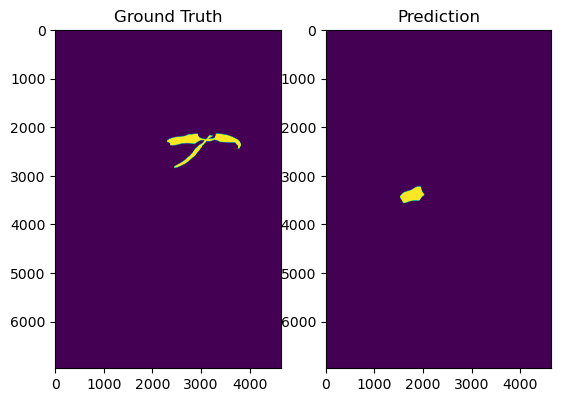


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5856.JPG
Prediction pixel count:  0
Ground truth pixel count:  134706
IOU: 0.0
Dice: 0.0


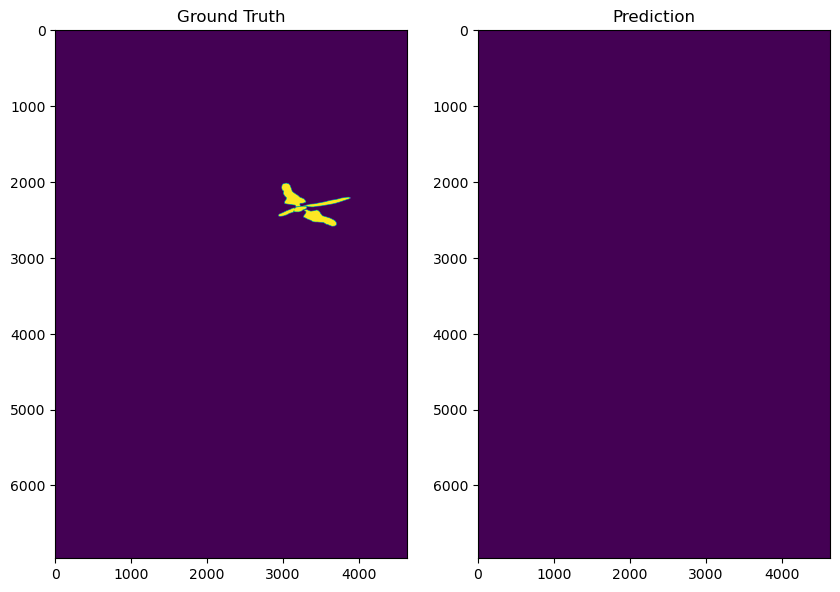


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5862.JPG
Prediction pixel count:  0
Ground truth pixel count:  90729
IOU: 0.0
Dice: 0.0


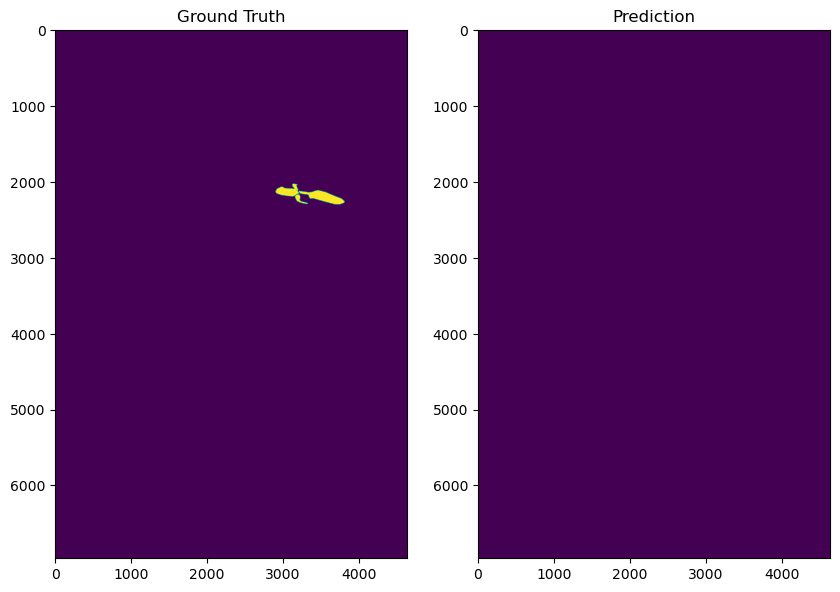


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5873.JPG
Prediction pixel count:  82904
Ground truth pixel count:  89870
IOU: 0.796118220660547
Dice: 0.8864875502101011


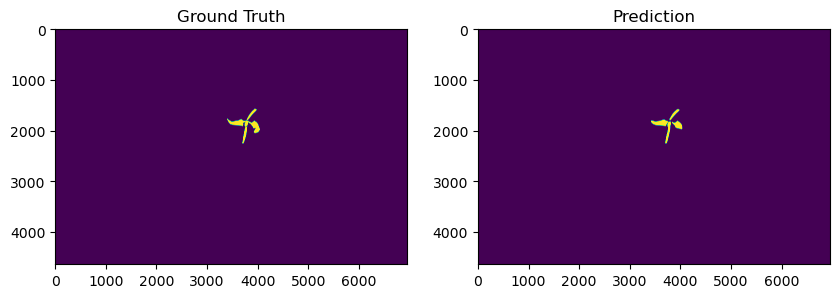


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5874.JPG
Prediction pixel count:  66542
Ground truth pixel count:  69813
IOU: 0.7214584201290257
Dice: 0.8381944189798687


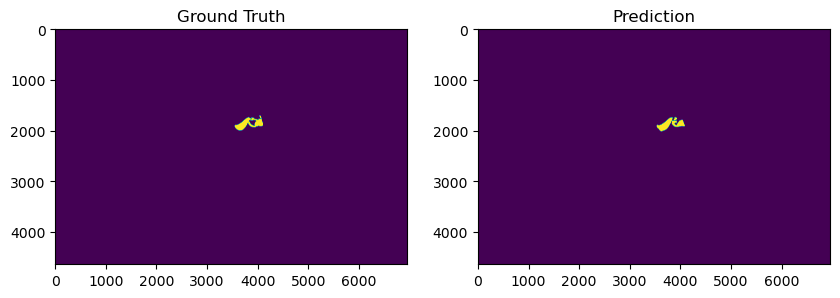


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5875.JPG
Prediction pixel count:  106938
Ground truth pixel count:  101283
IOU: 0.879742892995459
Dice: 0.9360247045206775


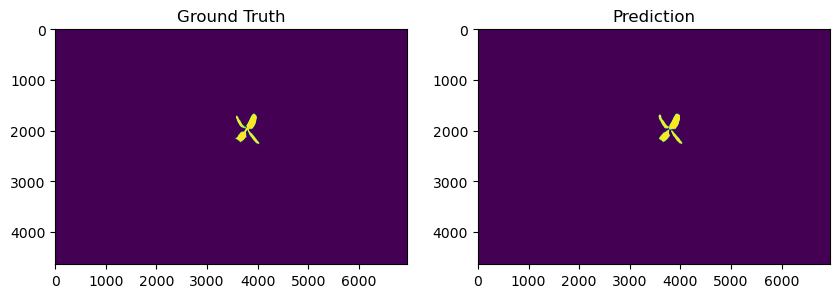


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5910.JPG
Prediction pixel count:  42576
Ground truth pixel count:  49721
IOU: 0.7336025544703231
Dice: 0.8463330335763892


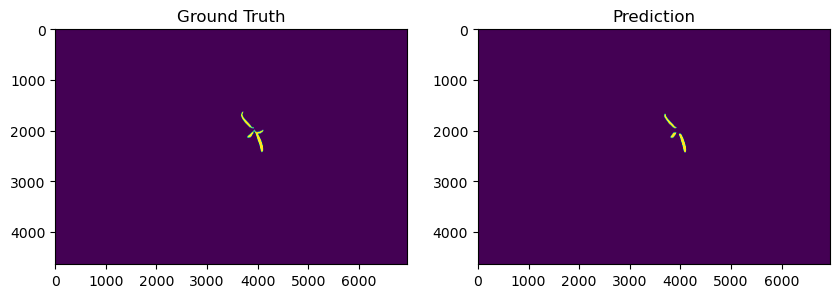


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5913.JPG
Prediction pixel count:  34045
Ground truth pixel count:  37103
IOU: 0.8271186440677966
Dice: 0.9053803339517625


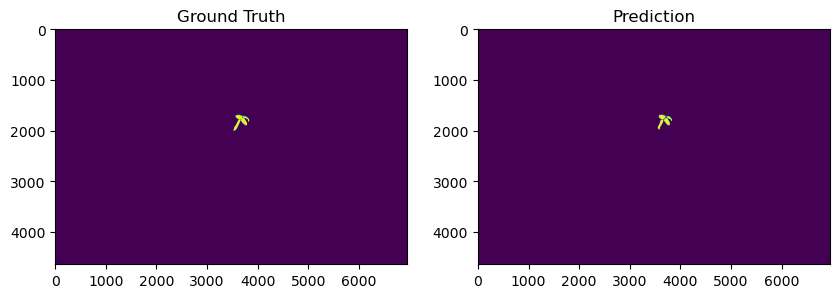


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5914.JPG
Prediction pixel count:  66177
Ground truth pixel count:  83186
IOU: 0.6873552570634553
Dice: 0.8147131485039802


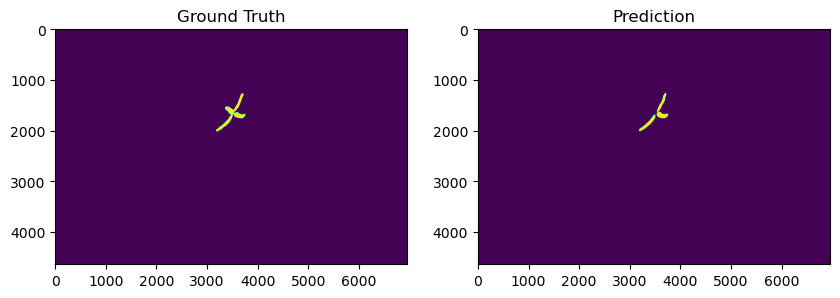


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5919.JPG
Prediction pixel count:  0
Ground truth pixel count:  0
IOU: None
Dice: None


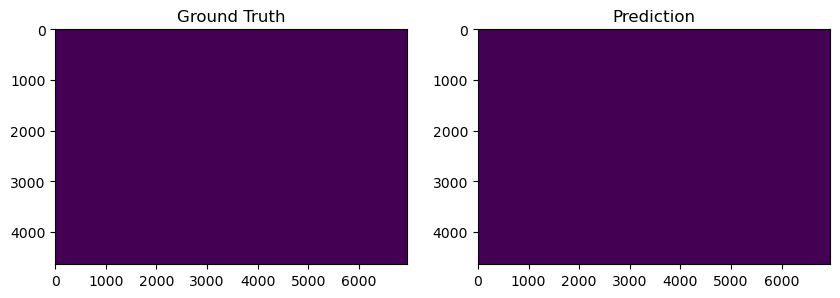


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5922.JPG
Prediction pixel count:  46011
Ground truth pixel count:  53091
IOU: 0.720819586733808
Dice: 0.8377631127525176


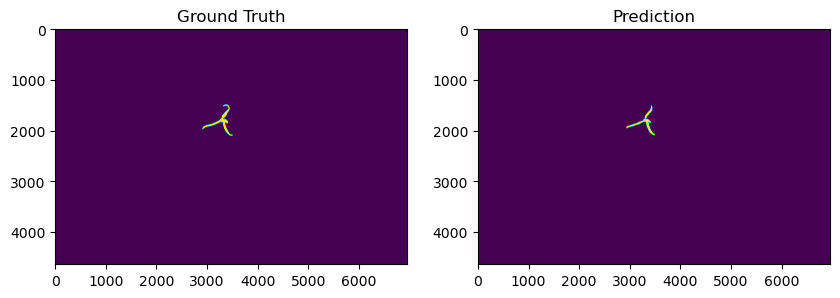


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5925.JPG
Prediction pixel count:  76775
Ground truth pixel count:  4330
IOU: 0.05632977337848398
Dice: 0.10665187103137908


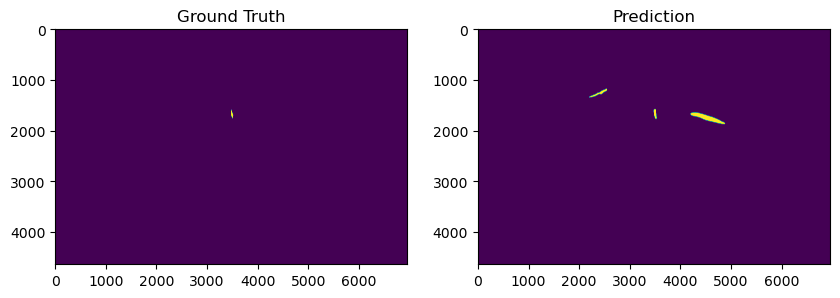


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5933.JPG
Prediction pixel count:  28848
Ground truth pixel count:  30743
IOU: 0.8228006851829194
Dice: 0.9027873336577671


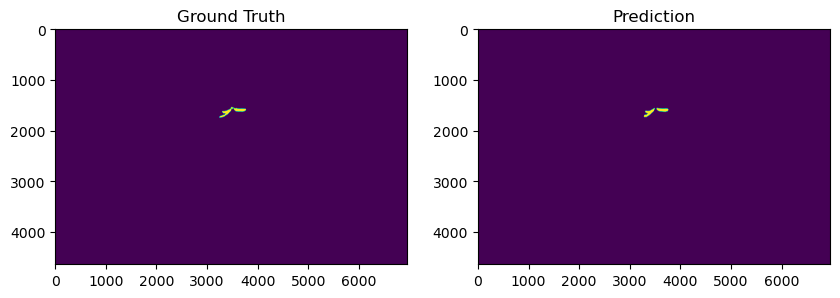


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5935.JPG
Prediction pixel count:  50535
Ground truth pixel count:  51567
IOU: 0.8667519882987476
Dice: 0.9286203992086345


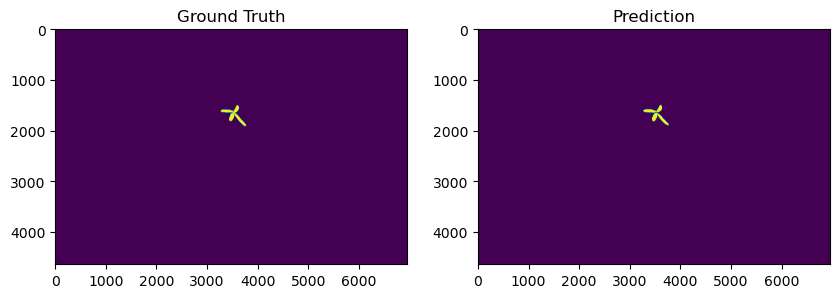


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5936.JPG
Prediction pixel count:  20996
Ground truth pixel count:  28904
IOU: 0.6027494057943085
Dice: 0.7521442885771543


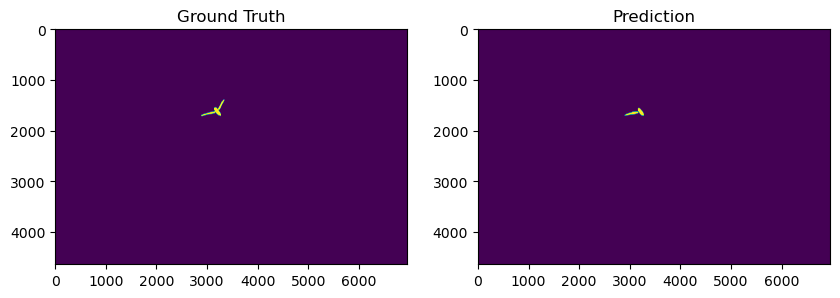


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5937.JPG
Prediction pixel count:  69973
Ground truth pixel count:  86629
IOU: 0.45780698733045994
Dice: 0.6280762697794409


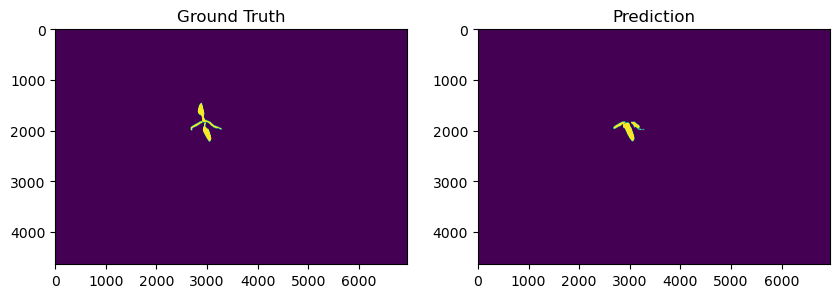


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5938.JPG
Prediction pixel count:  39900
Ground truth pixel count:  40564
IOU: 0.51896249032526
Dice: 0.6833117916086697


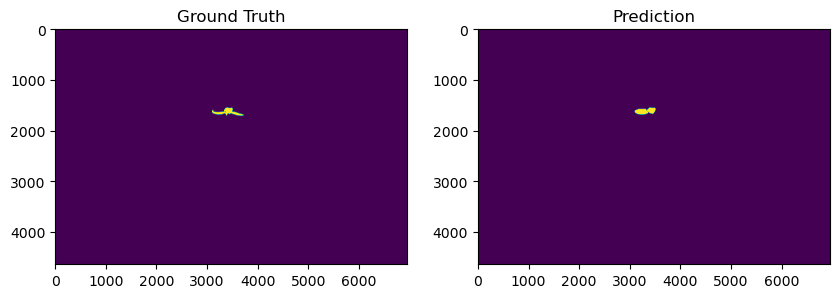


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5939.JPG
Prediction pixel count:  33136
Ground truth pixel count:  33930
IOU: 0.8073191764579066
Dice: 0.8933886022723884


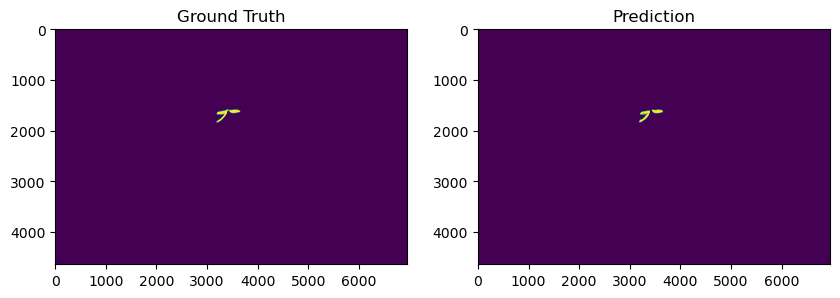


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5947.JPG
Prediction pixel count:  582457
Ground truth pixel count:  576789
IOU: 0.8783191719650276
Dice: 0.9352182366814291


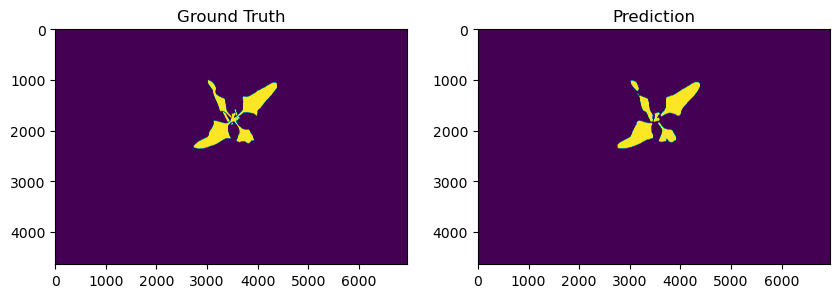


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5953.JPG
Prediction pixel count:  93946
Ground truth pixel count:  111934
IOU: 0.7427371842622063
Dice: 0.8523800272003108


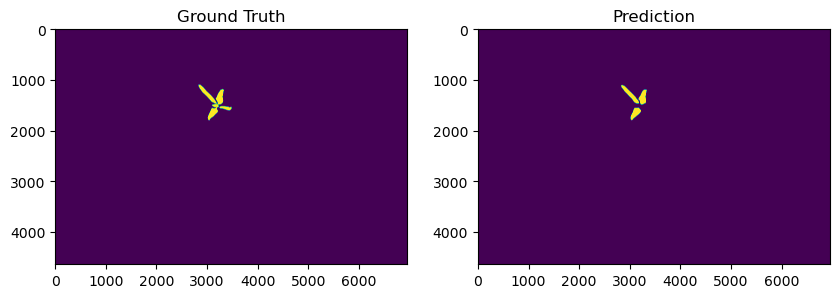


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5955.JPG
Prediction pixel count:  900297
Ground truth pixel count:  911818
IOU: 0.9052953756411038
Dice: 0.9502939934827536


/tmp/ipykernel_189/5610809.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1, 2)


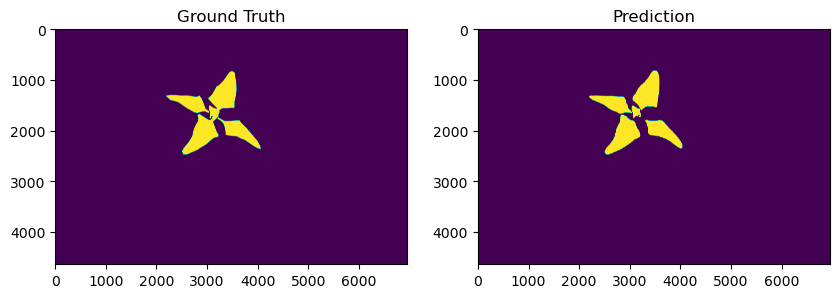


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5968.JPG
Prediction pixel count:  446074
Ground truth pixel count:  420202
IOU: 0.8720294242858408
Dice: 0.9316407242033716


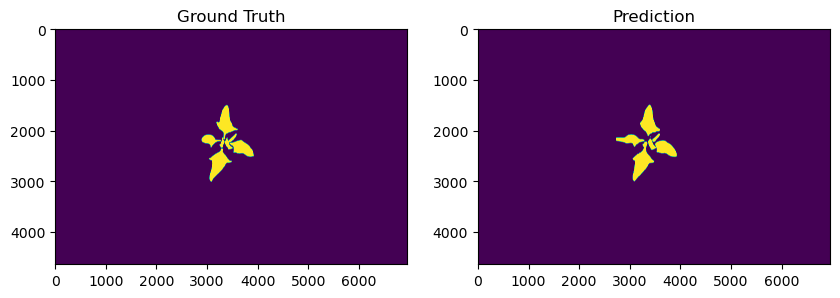


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5969.JPG
Prediction pixel count:  434017
Ground truth pixel count:  452161
IOU: 0.9013675939872209
Dice: 0.9481255458835584


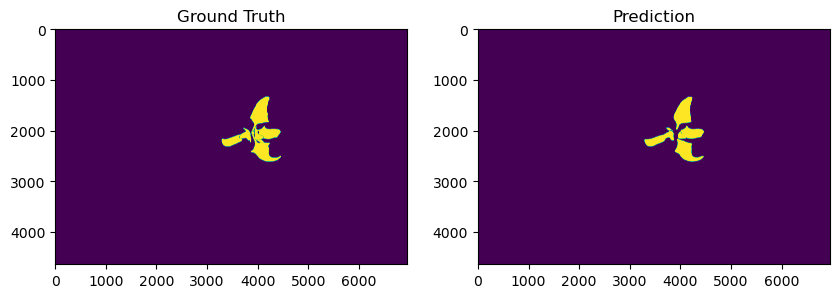


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5971.JPG
Prediction pixel count:  770181
Ground truth pixel count:  761092
IOU: 0.9154512203664602
Dice: 0.9558596017823079


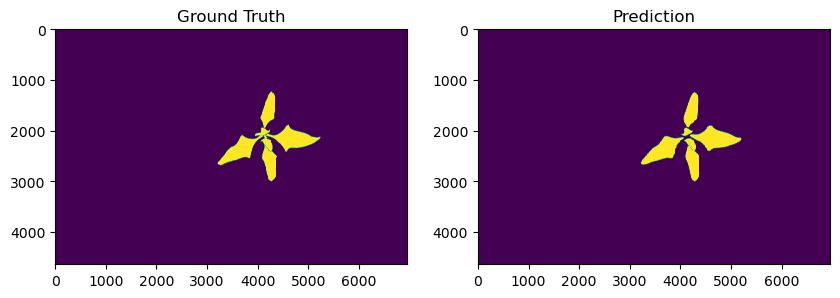


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5972.JPG
Prediction pixel count:  114429
Ground truth pixel count:  114276
IOU: 0.8544901682546118
Dice: 0.9215364771211824


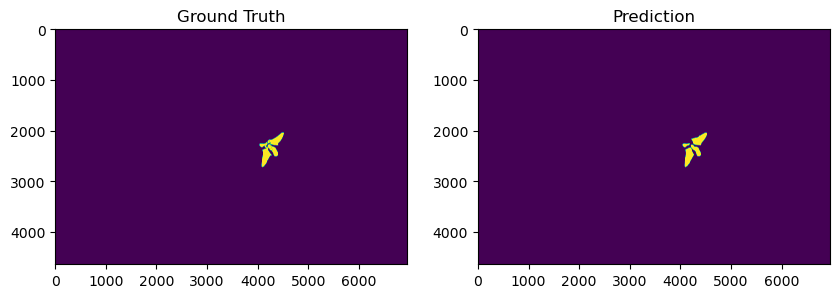


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5978.JPG
Prediction pixel count:  6460
Ground truth pixel count:  30072
IOU: 0.20507999340260596
Dice: 0.3403591371947881


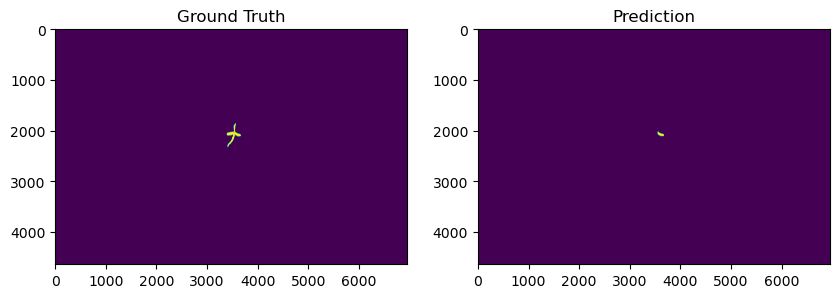


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5987.JPG
Prediction pixel count:  9750
Ground truth pixel count:  7451
IOU: 0.58286555627128
Dice: 0.7364688099529098


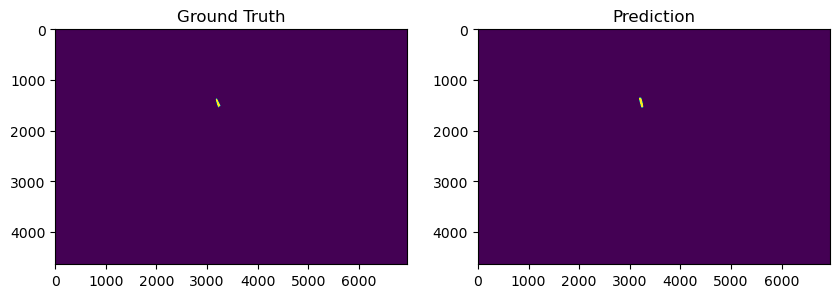


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5995.JPG
Prediction pixel count:  994482
Ground truth pixel count:  991200
IOU: 0.893986535853203
Dice: 0.9440262841683613


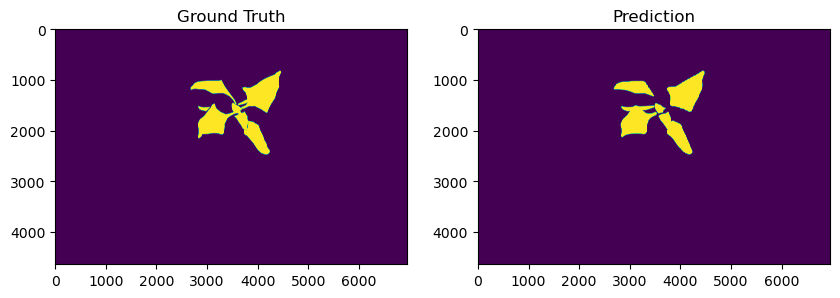


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6016.JPG
Prediction pixel count:  72432
Ground truth pixel count:  89651
IOU: 0.7361819272462402
Dice: 0.8480469882714412


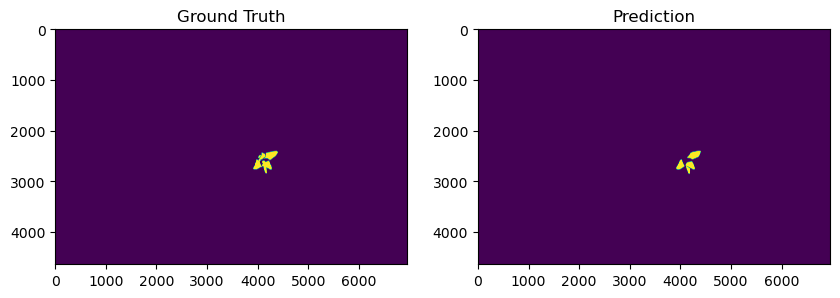


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6024.JPG
Prediction pixel count:  149099
Ground truth pixel count:  158811
IOU: 0.8414128003636059
Dice: 0.9138774317170602


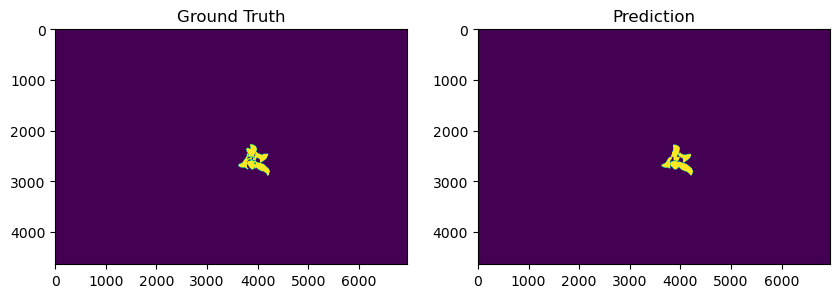


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6027.JPG
Prediction pixel count:  88048
Ground truth pixel count:  66241
IOU: 0.4454927017557009
Dice: 0.6163887250549294


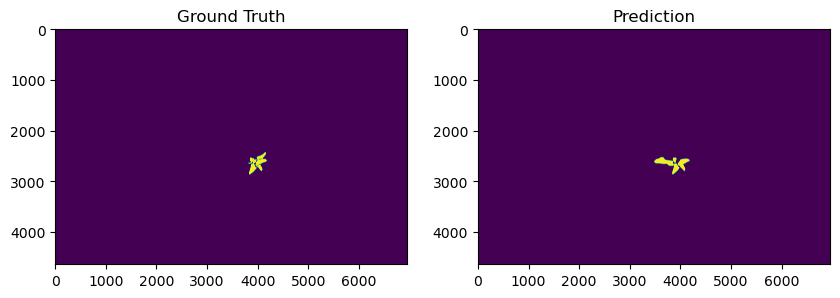


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6028.JPG
Prediction pixel count:  8273
Ground truth pixel count:  12921
IOU: 0.48272002238701556
Dice: 0.6511276776446164


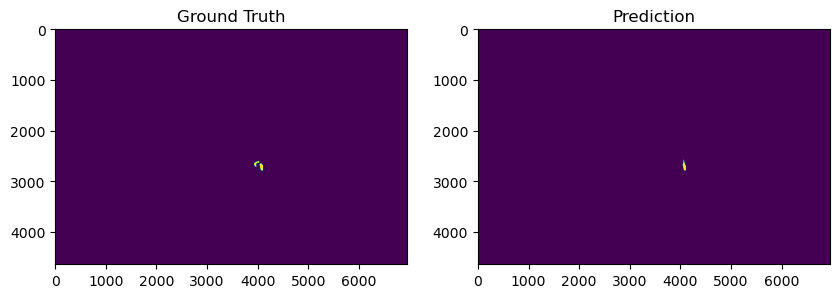


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6034.JPG
Prediction pixel count:  232632
Ground truth pixel count:  249294
IOU: 0.8898021285105916
Dice: 0.9416881429929076


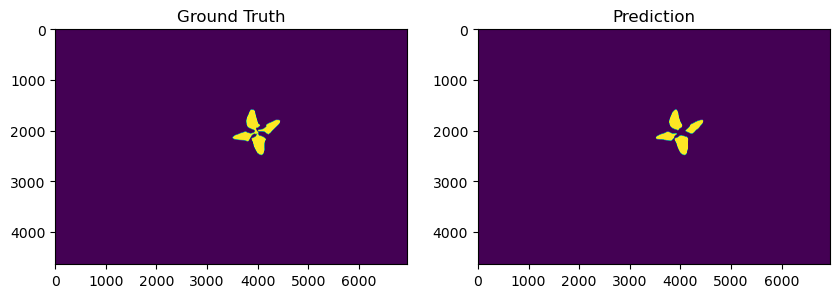


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6040.JPG
Prediction pixel count:  233132
Ground truth pixel count:  378902
IOU: 0.5584011488750599
Dice: 0.7166333896482875


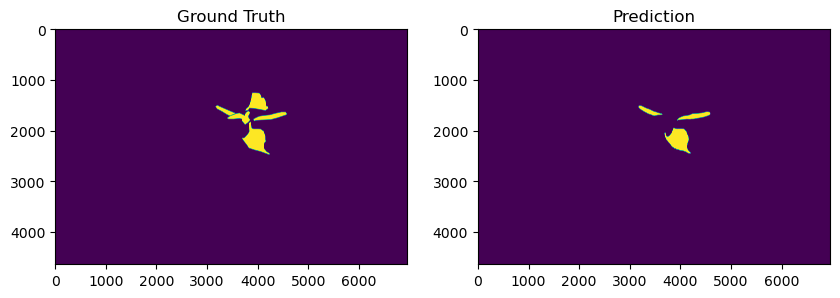


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6042.JPG
Prediction pixel count:  226354
Ground truth pixel count:  184502
IOU: 0.7463689572946022
Dice: 0.8547666335650447


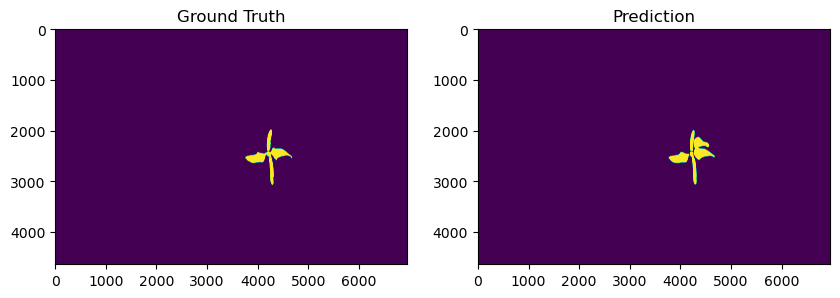

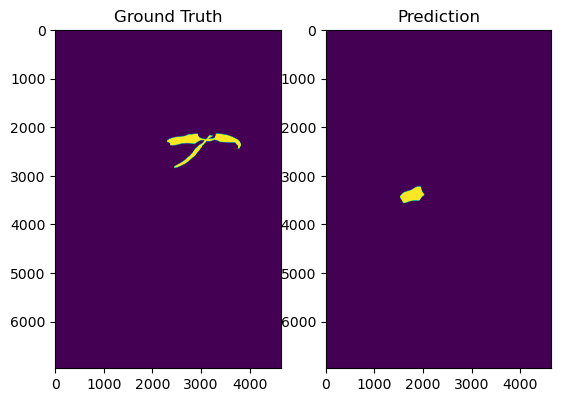

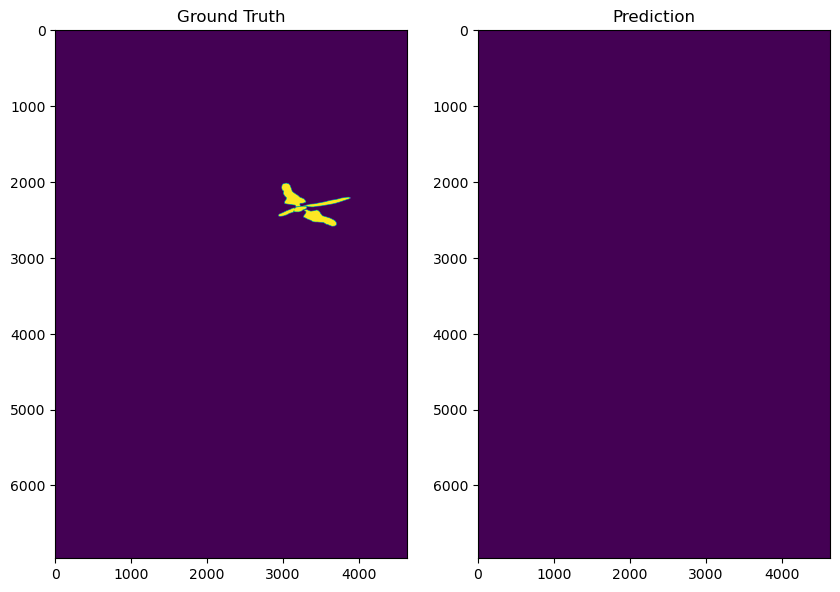

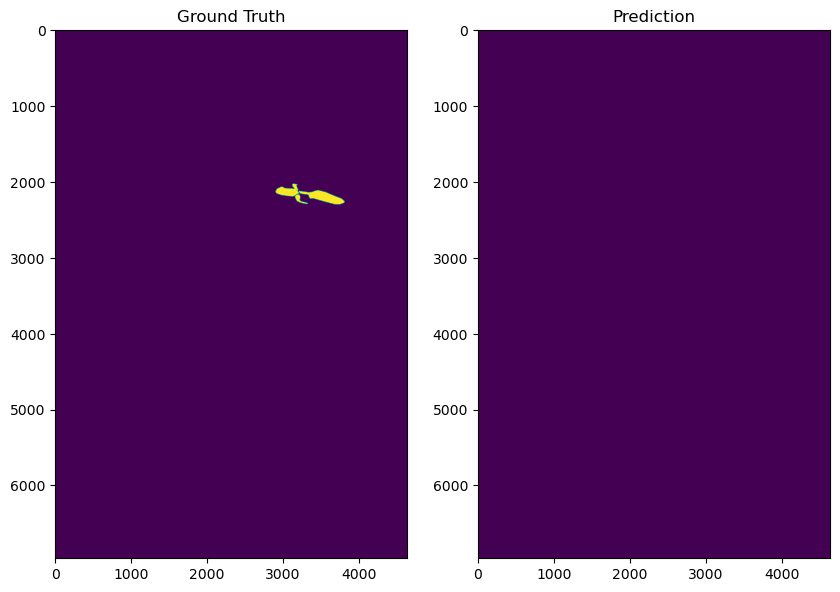

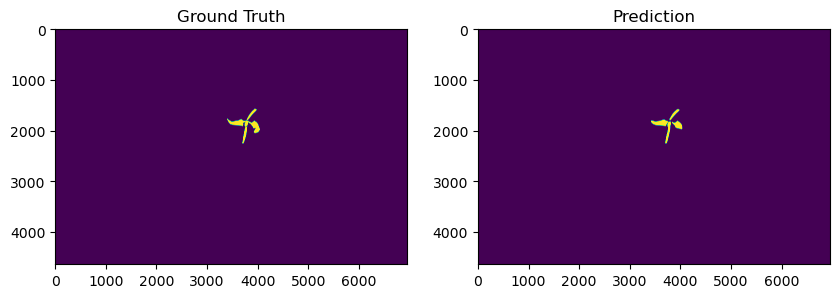

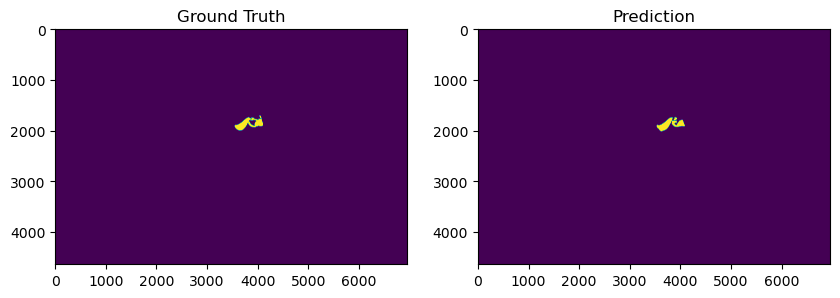

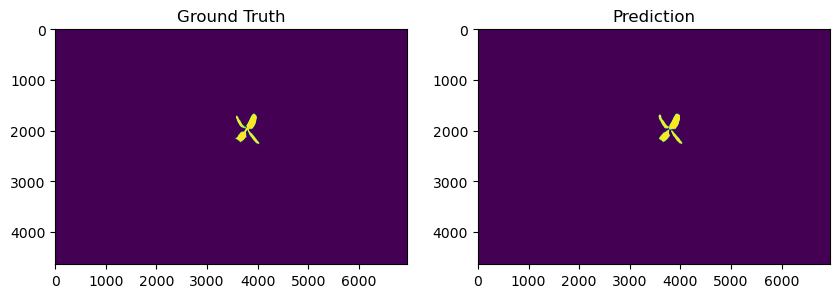

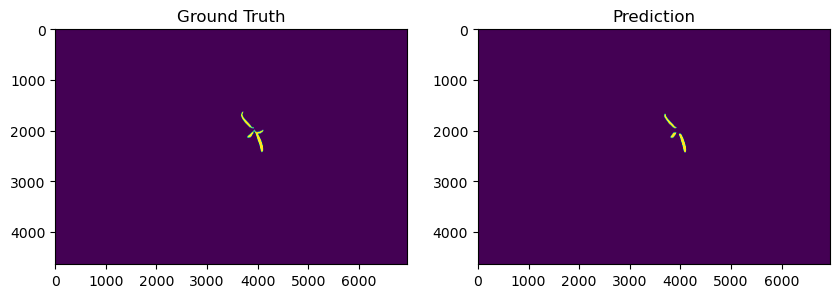

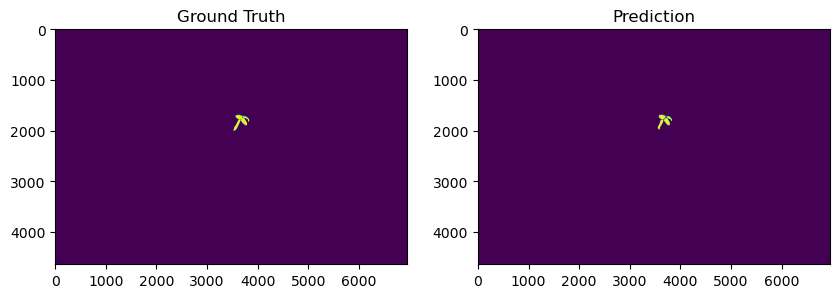

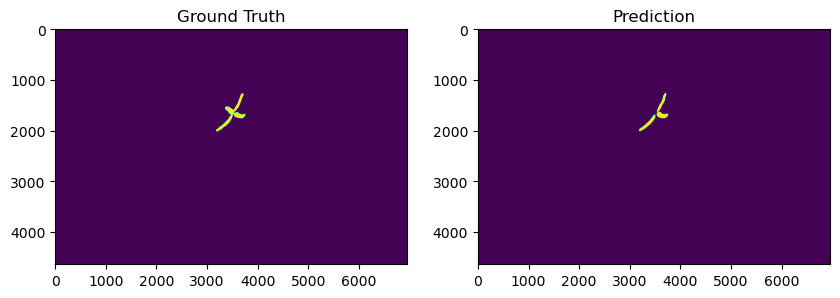

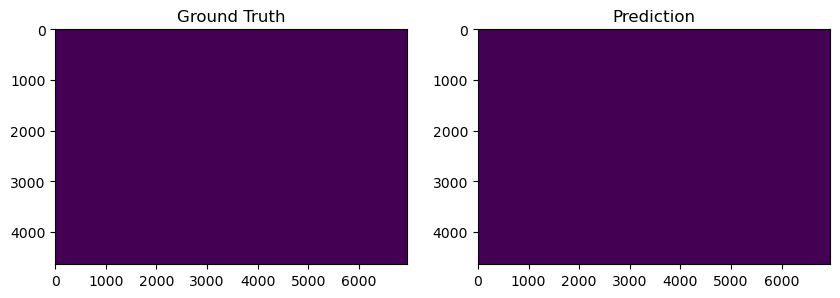

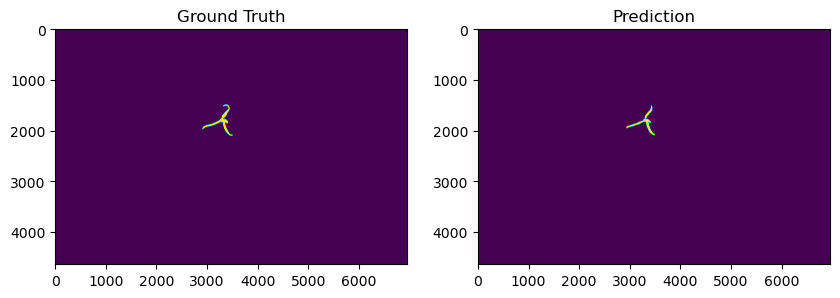

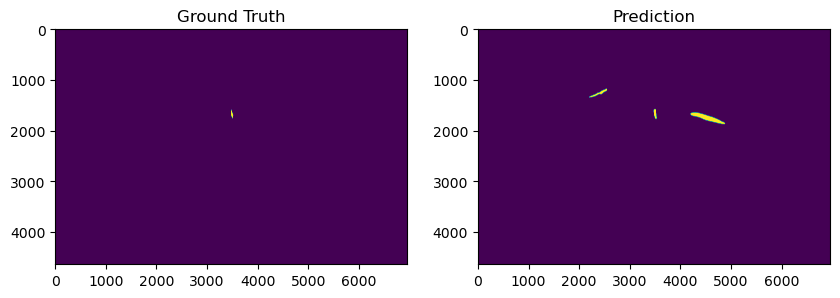

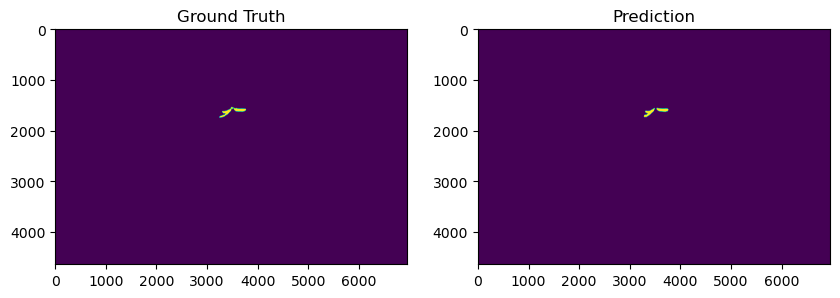

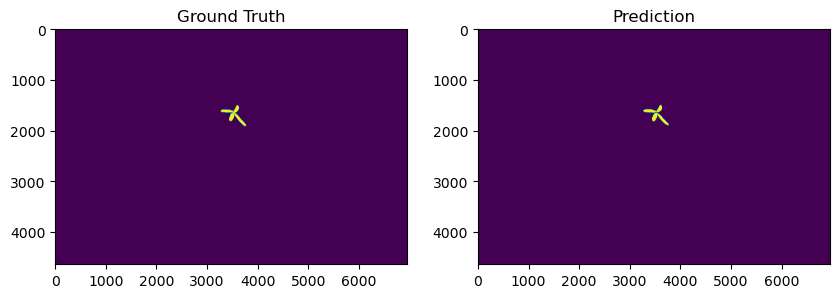

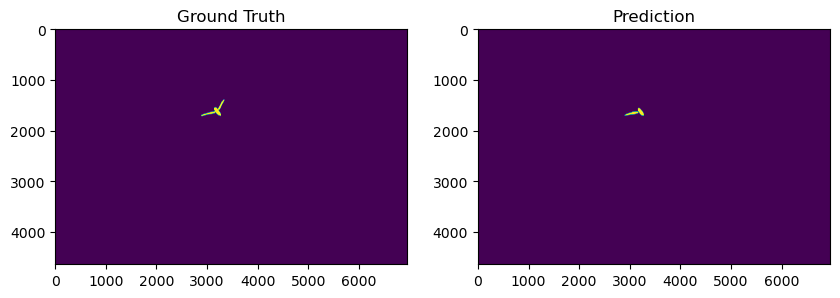

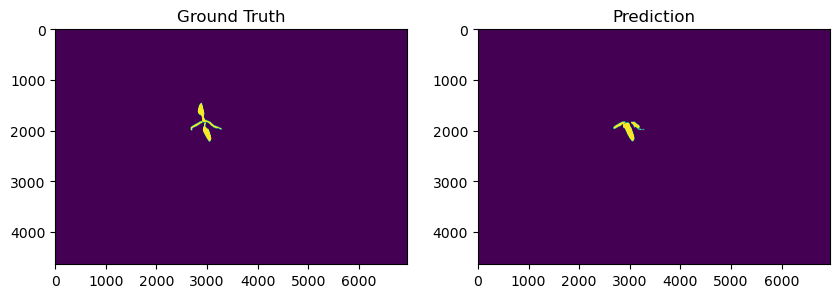

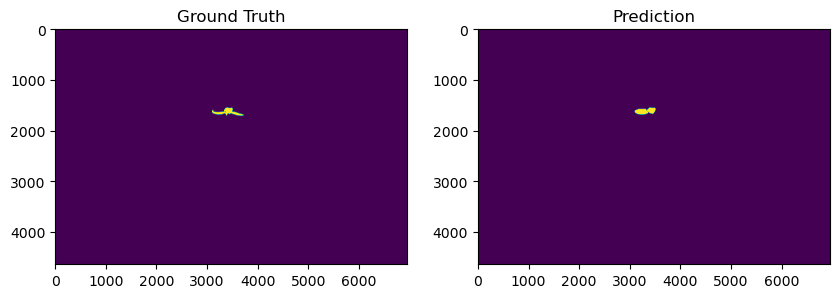

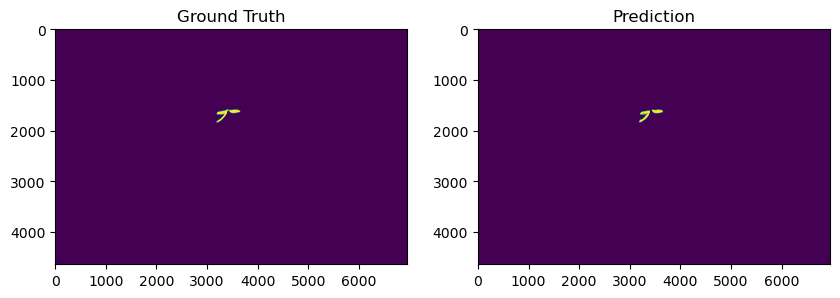

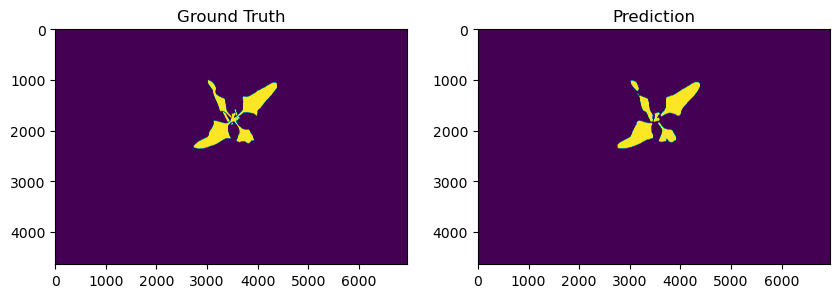

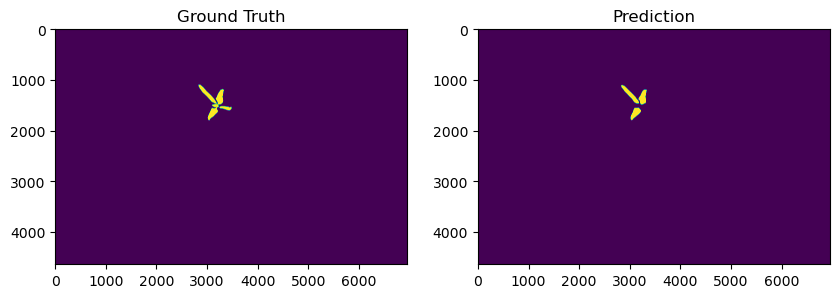

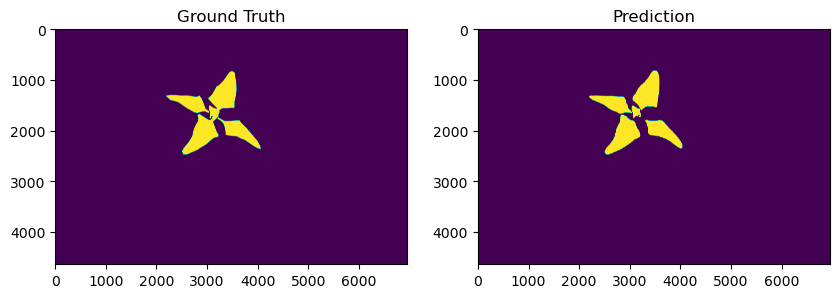

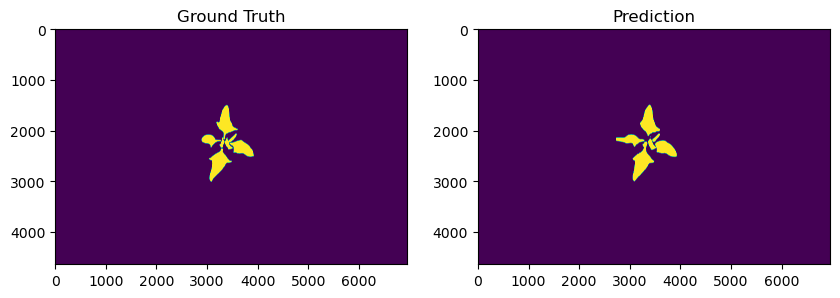

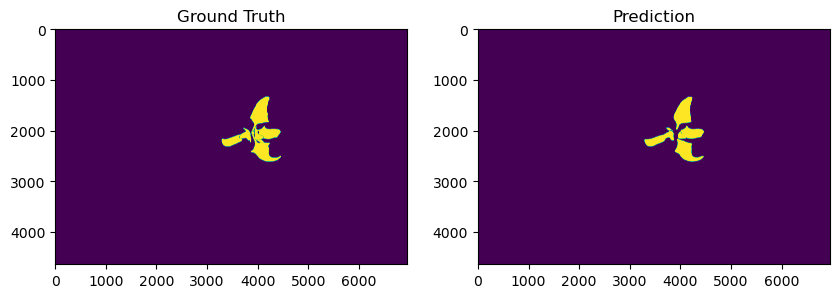

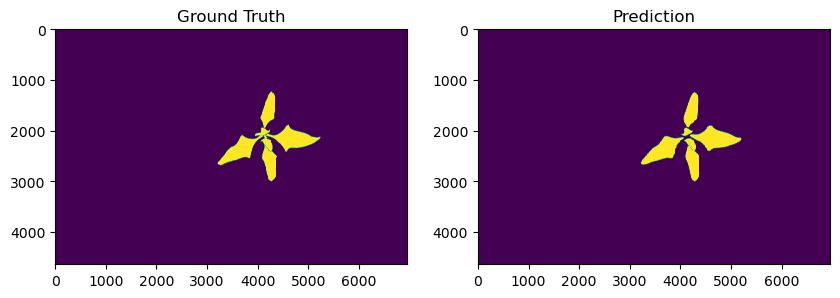

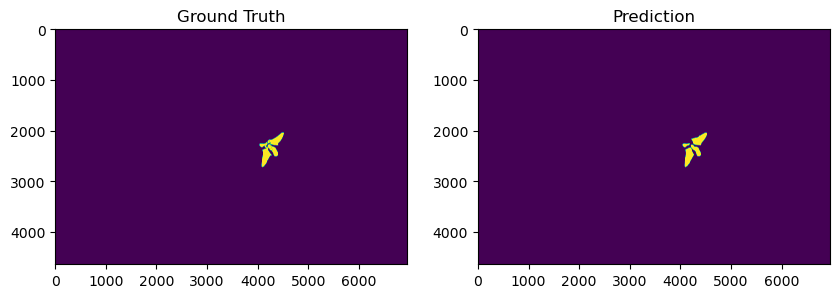

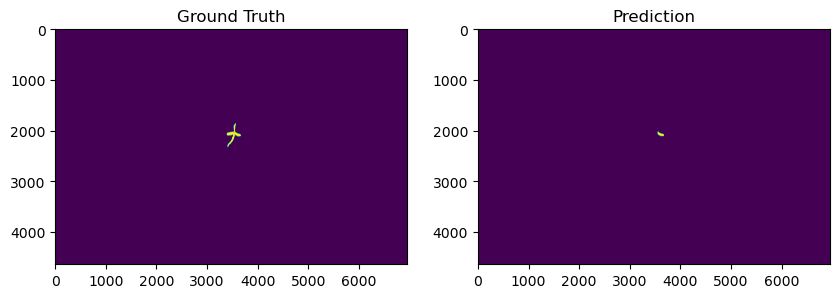

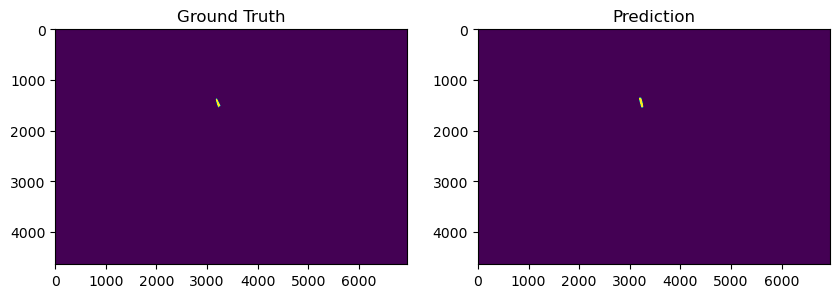

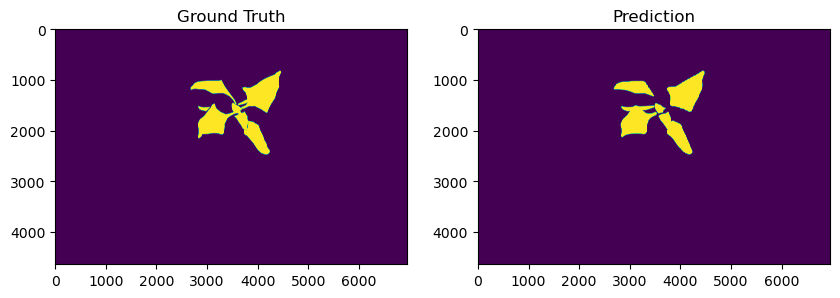

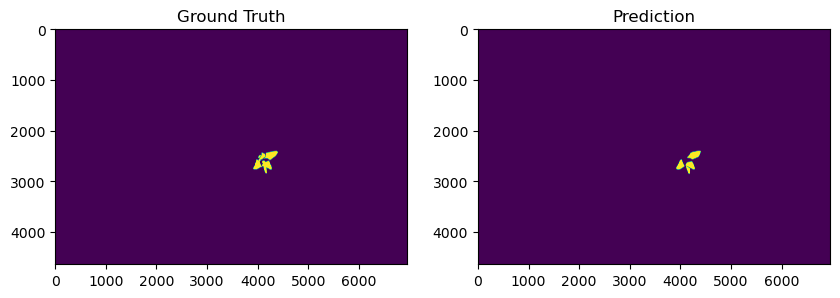

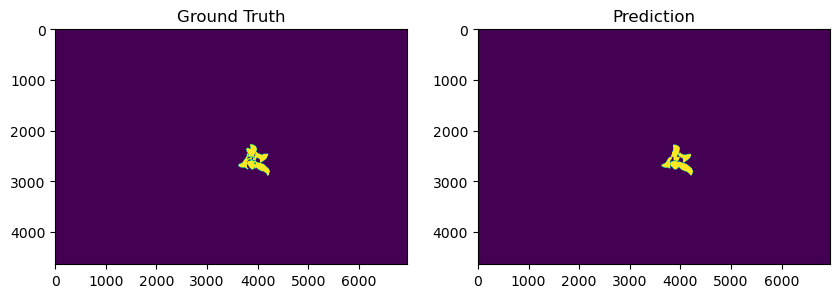

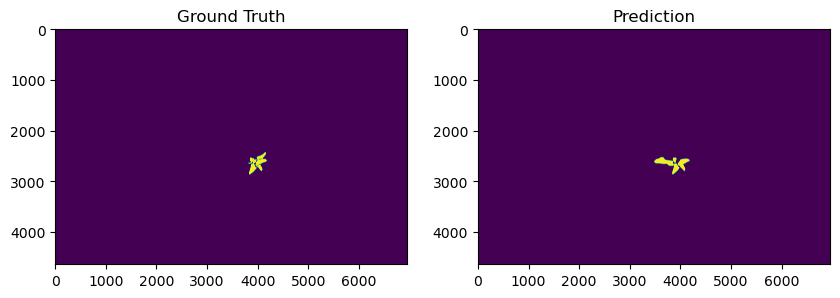

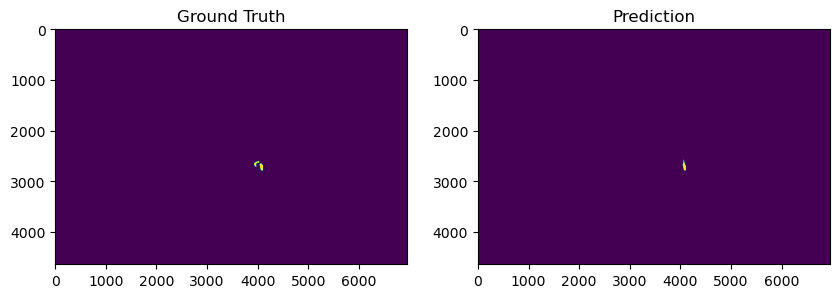

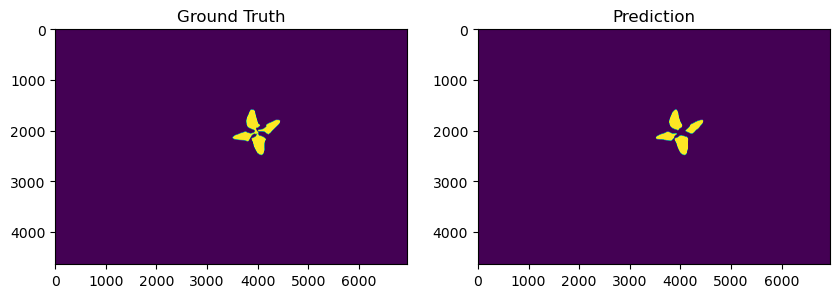

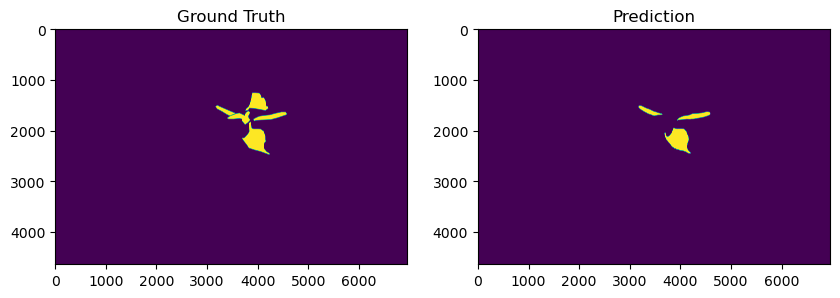

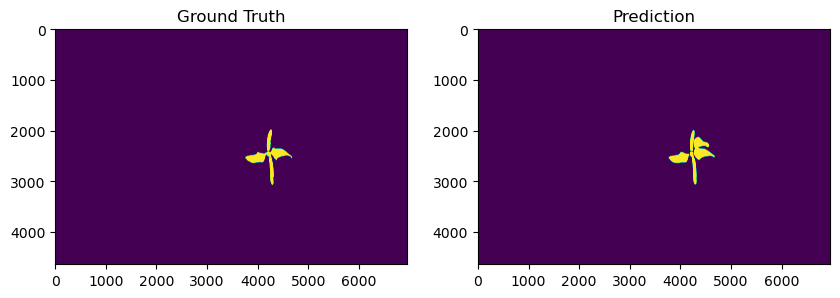

In [22]:
sample_ious = []
sample_dice = []

# sample = dataset.last()
for sample in dataset:
    
    print('\n --------------------------------------------------------------')
    print('\nSample: ', sample.filepath)

    # ------- get bboxes & masks for GROUND TRUTH and PREDICTIONS ------ #

    ground_truth_detections = sample.ground_truth.detections
    prediction_detections = sample.predictions.detections

    height = sample.height
    width  = sample.width

    ground_truth_bboxes = []
    ground_truth_masks = []

    prediction_bboxes = []
    prediction_masks = []
    detectron2_bboxes = []


    # get bboxes and masks from ground truth
    for d in ground_truth_detections:
        if (d.label == 'leaf'):
            ground_truth_bboxes.append(d.bounding_box)
            ground_truth_masks.append(d.mask)

    # get bboxes and masks from predictions
    for d in prediction_detections:
        if (d.label == 'leaf'):
            prediction_bboxes.append(d.bounding_box)
            prediction_masks.append(d.mask)
            detectron2_bboxes.append(d.original_bbox)



    # ---------- assemble PREDICTION mask for entire photo ------------ #
    complete_prediction_mask = np.zeros((height, width))


    for index, bbox in enumerate(prediction_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)], prediction_masks[index])

    print('Prediction pixel count: ', np.count_nonzero(complete_prediction_mask))



    # --------- assemble GROUND TRUTH mask for entire photo ----------- #
    complete_ground_truth_mask = np.zeros((height, width))

    for index, bbox in enumerate(ground_truth_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)], ground_truth_masks[index])

    print('Ground truth pixel count: ', np.count_nonzero(complete_ground_truth_mask))
    
    
     # ------- calculate Intersection Over Union (Jaccard Index) ------- #

    intersect = np.logical_and(complete_ground_truth_mask, complete_prediction_mask)
    union = np.logical_or(complete_ground_truth_mask, complete_prediction_mask)

    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    iou = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        iou = intersect_pixels / union_pixels

    print('IOU:', iou)
    sample_ious.append(iou)
    
    # ------------ calculate Dice Coefficient (F1 Score) -------------- #
    
    dice = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        dice = (2 * intersect_pixels) / (np.count_nonzero(complete_ground_truth_mask) + np.count_nonzero(complete_prediction_mask))

    print('Dice:', dice)
    sample_dice.append(dice)

    # --------- visualize GROUND TRUTH and PREDICTION masks ----------- #
    # if 'IMG_6153' in sample.filepath:
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')

    axarr[0].imshow(complete_ground_truth_mask)
    axarr[1].imshow(complete_prediction_mask)

    display(f)
 

In [23]:
print(sample_ious)

sample_ious = np.array(sample_ious, dtype=float)

print(sample_ious)

# sample_ious[sample_ious == None] = np.nan

print('Min IOU: ', np.nanmin(sample_ious))
print('Max IOU: ', np.nanmax(sample_ious))
print('Average IOU: ', np.nanmean(sample_ious))

print('\n')
# sample_dice[sample_dice == None] = np.nan

sample_dice = np.array(sample_dice, dtype=float)

print('Min Dice: ', np.nanmin(sample_dice))
print('Max Dice: ', np.nanmax(sample_dice))
print('Average Dice: ', np.nanmean(sample_dice))





[0.0, 0.0, 0.0, 0.796118220660547, 0.7214584201290257, 0.879742892995459, 0.7336025544703231, 0.8271186440677966, 0.6873552570634553, None, 0.720819586733808, 0.05632977337848398, 0.8228006851829194, 0.8667519882987476, 0.6027494057943085, 0.45780698733045994, 0.51896249032526, 0.8073191764579066, 0.8783191719650276, 0.7427371842622063, 0.9052953756411038, 0.8720294242858408, 0.9013675939872209, 0.9154512203664602, 0.8544901682546118, 0.20507999340260596, 0.58286555627128, 0.893986535853203, 0.7361819272462402, 0.8414128003636059, 0.4454927017557009, 0.48272002238701556, 0.8898021285105916, 0.5584011488750599, 0.7463689572946022]
[0.         0.         0.         0.79611822 0.72145842 0.87974289
 0.73360255 0.82711864 0.68735526        nan 0.72081959 0.05632977
 0.82280069 0.86675199 0.60274941 0.45780699 0.51896249 0.80731918
 0.87831917 0.74273718 0.90529538 0.87202942 0.90136759 0.91545122
 0.85449017 0.20507999 0.58286556 0.89398654 0.73618193 0.8414128
 0.4454927  0.48272002 0.889

In [24]:
total_dice = 0.7693692302489409 + 0.9192198343808647 + 0.8494511989802144 + 0.773003970816042 + 0.9131756362004316
avg_dice = total_dice / 5
print(avg_dice)

0.8448439741252987


In [25]:
total_r2 = 0.7996748496587117 + 0.9963375296453822 + 0.9725001037237607 + 0.9946219916894515 + 0.9971855695035271
avg_r2 = total_r2 / 5
print(avg_r2)

0.9520640088441666
